In [1]:
import numpy as np
import pandas as pd
import pandasql as sql
import holidays
import pandas_profiling as prof
from itertools import chain
import pmdarima as pm
from pmdarima.model_selection import train_test_split
from pmdarima.arima import ndiffs
from pmdarima.arima import ADFTest
import datetime
import multiprocessing as mp
import pyproj
import matplotlib.pyplot as plt
import geobr
import seaborn as sns
import matplotlib.pyplot as plt
import mapclassify as mc
from sklearn.metrics import mean_absolute_error
import os
import warnings
from sklearn.model_selection import TimeSeriesSplit

plt.style.use('classic')
%matplotlib inline
np.random.seed(12345)
os.chdir("C:\\Users\\Caio Serrano\\Google Drive\\4-MacBook Pro\\Py - Codes\\DataScienceGit\\DataScienceProjects\\Geospatial\\dataset")
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 500)
warnings.filterwarnings('ignore')

Can't load requested DLL: C:\Program Files\GDAL\gdalplugins\gdal_KEA.dll
127: The specified procedure could not be found.

Can't load requested DLL: C:\Program Files\GDAL\gdalplugins\gdal_KEA.dll
127: The specified procedure could not be found.

Can't load requested DLL: C:\Program Files\GDAL\gdalplugins\gdal_KEA.dll
127: The specified procedure could not be found.

Can't load requested DLL: C:\Program Files\GDAL\gdalplugins\gdal_KEA.dll
127: The specified procedure could not be found.



In [2]:
def loadData():
    """
    Returning GeoPandas for Customer and Seller
    """
    cust = pd.read_csv('../dataset/olist_customers_dataset.csv')
    geo = pd.read_csv('../dataset/olist_geolocation_dataset.csv')
    ord_itens = pd.read_csv('../dataset/olist_order_items_dataset.csv')
    ord_pymt = pd.read_csv('../dataset/olist_order_payments_dataset.csv')
    ord_rev = pd.read_csv('../dataset/olist_order_reviews_dataset.csv')
    fact_ord = pd.read_csv('../dataset/olist_orders_dataset.csv')
    prdts = pd.read_csv('../dataset/olist_products_dataset.csv')
    seller = pd.read_csv('../dataset/olist_sellers_dataset.csv')
    geo_avg = sql.sqldf("""
                    SELECT
                    geolocation_zip_code_prefix geolocation_zip_code_prefix,
                    geolocation_city geolocation_city,
                    geolocation_state geolocation_state,
                    AVG(geolocation_lat) geolocation_lat,
                    AVG(geolocation_lng) geolocation_lng
                    FROM geo f
                    GROUP BY 1,2,3
                    """)

    geo_poly_sp = sql.sqldf("""
                    SELECT
                    *
                    FROM
                    (
                        SELECT
                        geolocation_zip_code_prefix geolocation_zip_code_prefix,
                        geolocation_city geolocation_city,
                        geolocation_state geolocation_state,
                        geolocation_lat geolocation_lat,
                        geolocation_lng geolocation_lng,
                        COUNT(CAST(geolocation_lat AS VARCHAR(1000)) + '-' + CAST(geolocation_lng AS VARCHAR(1000))) poly_check
                        FROM geo f
                        GROUP BY 1,2,3,4,5
                    )
                    WHERE poly_check >= 3
                    AND geolocation_state = 'SP'
                    """)
    query = sql.sqldf("""
                    SELECT
                    f.order_id order_nr,
                    f.*,
                    it.*,
                    prdts.*,
                    s.*,
                    c.*,
                    p.*,
                    r.*
                    FROM fact_ord f
                    LEFT JOIN ord_itens it ON f.order_id = it.order_id
                    LEFT JOIN prdts prdts ON it.product_id = prdts.product_id
                    LEFT JOIN seller s ON it.seller_id = s.seller_id
                    LEFT JOIN cust c ON f.customer_id = c.customer_id
                    LEFT JOIN ord_pymt p ON f.order_id = p.order_id
                    LEFT JOIN ord_rev r ON f.order_id = r.order_id
                    """)

    orders = pd.DataFrame(query)
    orders.drop(columns=['order_id'], inplace=True)
    orders['total_value'] = orders['price'] + orders['freight_value']
    orders['order_status'].drop_duplicates()
    orders_approved = orders[(orders['order_status'] == 'approved') 
                             | (orders['order_status'] == 'delivered') 
                             & (orders['product_category_name'].isnull() == False)][['order_purchase_timestamp','product_category_name','total_value','customer_city','customer_state','price','freight_value']]
    orders_approved['order_purchase_timestamp'] = pd.to_datetime(orders_approved['order_purchase_timestamp'])
    orders_approved['order_purchase_year'] = orders_approved['order_purchase_timestamp'].dt.year
    orders_approved['order_purchase_month'] = orders_approved['order_purchase_timestamp'].dt.month
    orders_approved['order_purchase_day'] = orders_approved['order_purchase_timestamp'].dt.day
    orders_approved['order_purchase_week'] = orders_approved['order_purchase_timestamp'].dt.week
    orders_approved['order_purchase_hour'] = orders_approved['order_purchase_timestamp'].dt.hour
    orders_approved['order_purchase_minute'] = orders_approved['order_purchase_timestamp'].dt.minute
    orders_approved['order_purchase_weekday'] = orders_approved['order_purchase_timestamp'].dt.day_name()
    br_holidays = pd.DataFrame.from_dict(holidays.Brazil(years=[2016,2017,2018]), orient='index').rename(columns={0: "DAY_NAME"}).rename_axis("date")
    br_sp_holidays = pd.DataFrame.from_dict(holidays.Brazil(state='SP',years=[2016,2017,2018]), orient='index').rename(columns={0: "DAY_NAME"}).rename_axis("date")
    br_rj_holidays = pd.DataFrame.from_dict(holidays.Brazil(state='RJ',years=[2016,2017,2018]), orient='index').rename(columns={0: "DAY_NAME"}).rename_axis("date")
    br_mg_holidays = pd.DataFrame.from_dict(holidays.Brazil(state='MG',years=[2016,2017,2018]), orient='index').rename(columns={0: "DAY_NAME"}).rename_axis("date")
    orders_approved['order_purchase_timestamp_is_fed_holiday'] = orders_approved['order_purchase_timestamp'].dt.date.isin(br_holidays.index.to_list())
    return orders_approved
orders_approved = loadData()

<AxesSubplot:xlabel='order_purchase_year_month_day', ylabel='total_value'>

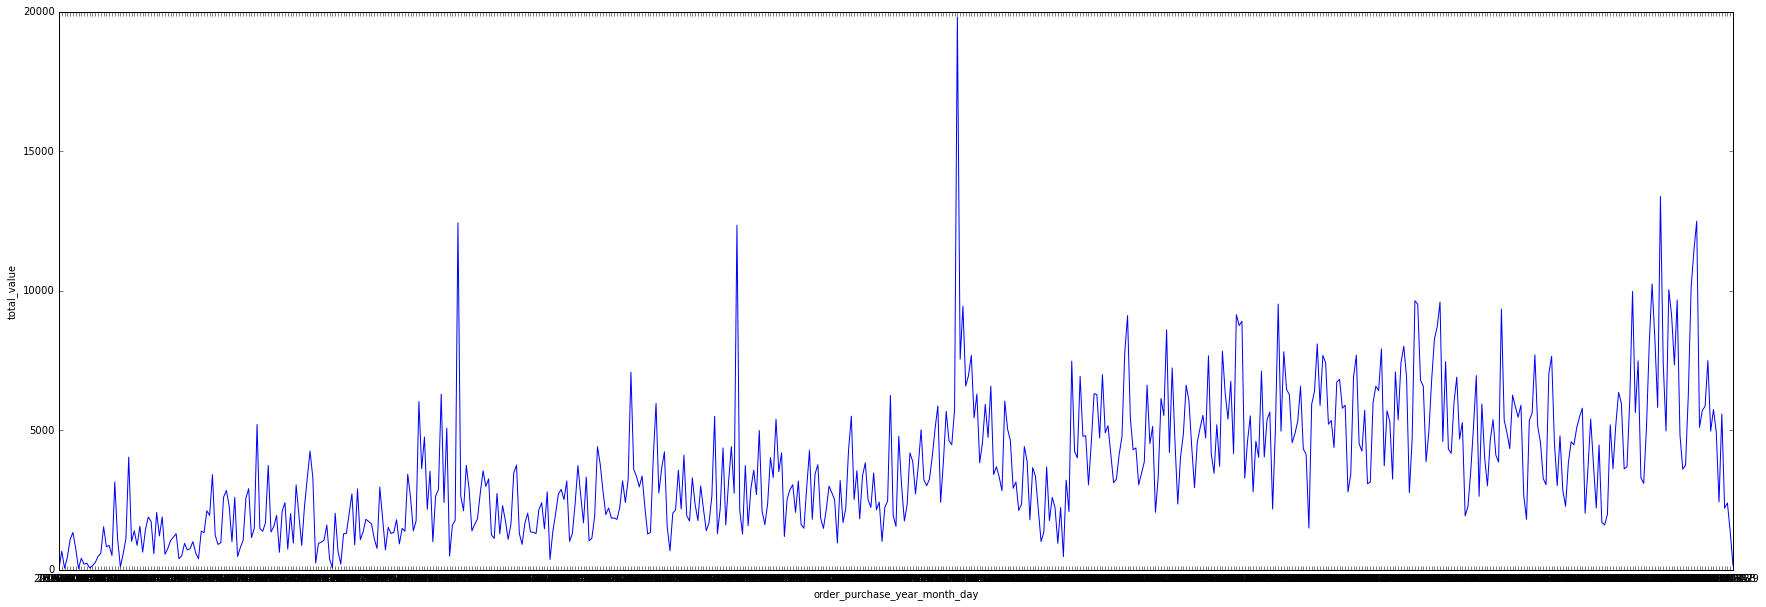

In [26]:
byWeekStates = orders_approved[orders_approved['customer_city'] == 'sao paulo'].groupby(['order_purchase_year','order_purchase_month','order_purchase_week','order_purchase_day','order_purchase_timestamp_is_fed_holiday'])['total_value'].sum().to_frame()
byWeekStates.reset_index(inplace=True)
byWeekStates['order_purchase_year_month_day'] = byWeekStates['order_purchase_year'].astype(str) +"-" + byWeekStates['order_purchase_month'].astype(str)+ "-" +byWeekStates['order_purchase_day'].astype(str)
byWeekStates.set_index('order_purchase_year_month_day', inplace = True)
byWeekStates = pd.get_dummies(byWeekStates, columns=['order_purchase_year','order_purchase_month','order_purchase_week','order_purchase_timestamp_is_fed_holiday']).drop('order_purchase_timestamp_is_fed_holiday_False', axis=1)
rolling_mean = byWeekStates['total_value'].rolling(window = 24).mean()
rolling_std = byWeekStates['total_value'].rolling(window = 24).std()
plt.figure(figsize=[30,10])
sns.lineplot(
        data=byWeekStates, x="order_purchase_year_month_day", y="total_value"
)

In [27]:
adf_test = ADFTest(alpha=0.05)
adf_test.should_diff(byWeekStates['total_value'])

(0.01, False)

In [23]:
y_train, y_test, x_train, x_test = train_test_split(byWeekStates['total_value'], byWeekStates.drop(['total_value'], axis=1), test_size=30)
np.array(round(y_train,1)).reshape(-1,1)

array([[1.43500e+02],
       [2.19900e+02],
       [2.59950e+03],
       [9.30500e+02],
       [3.03880e+03],
       [3.11570e+03],
       [2.91350e+03],
       [7.90700e+02],
       [9.38600e+02],
       [2.44000e+01],
       [2.15000e+01],
       [4.78000e+01],
       [1.41400e+02],
       [1.51400e+02],
       [4.25100e+02],
       [1.59800e+02],
       [6.09900e+02],
       [7.10800e+02],
       [4.04700e+02],
       [3.47000e+02],
       [1.82430e+03],
       [1.69000e+03],
       [1.44010e+03],
       [1.72630e+03],
       [1.50550e+03],
       [7.10700e+02],
       [2.22770e+03],
       [2.58450e+03],
       [2.62800e+03],
       [2.81040e+03],
       [6.20060e+03],
       [4.20150e+03],
       [3.04870e+03],
       [2.05700e+03],
       [3.49120e+03],
       [5.75870e+03],
       [2.65270e+03],
       [2.33110e+03],
       [3.75120e+03],
       [3.74180e+03],
       [2.62840e+03],
       [4.10570e+03],
       [6.96760e+03],
       [4.00190e+03],
       [3.30380e+03],
       [4.

In [ ]:
%%time
pool = mp.Pool(8) 
arima_model = pm.auto_arima(y = np.array(y_train).reshape(-1,1), exogenous= np.array(x_train), m = 365, start_p=1, start_q=1, stepwise=True, trace=True)
pool.close() 
pool.join()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,0,1)[365] intercept   : AIC=11139.630, Time=2281.14 sec
 ARIMA(0,0,0)(0,0,0)[365] intercept   : AIC=11165.106, Time=0.15 sec
 ARIMA(1,0,0)(1,0,0)[365] intercept   : AIC=inf, Time=1111.33 sec
 ARIMA(0,0,1)(0,0,1)[365] intercept   : AIC=inf, Time=1088.30 sec
 ARIMA(0,0,0)(0,0,0)[365]             : AIC=11163.106, Time=1.99 sec


In [19]:
predictions = arima_model.predict(n_periods=len(np.array(x_test)),exogenous=np.array(x_test))
predictions

array([ 76402.7037088 , 241770.05213713, 219330.5113513 , 239063.8413513 ,
       145716.15292297, 242656.58213713, 165265.5947414 , 245196.1563513 ,
       151848.46792297, 268261.72213713, 292297.70213713, 275451.32213713,
       209410.54213713, 116062.8537088 , 214059.81213713, 274072.73213713,
       246005.7363513 , 243682.04213713, 222200.13213713, 169093.51213713,
       269788.47213713, 278193.84213713, 289880.57213713, 277919.45213713,
       161223.62213713, 262429.51213713, 295738.05213713, 288978.23213713,
       265977.45213713, 261768.40213713])